Import things.

In [1]:
%matplotlib notebook
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astroquery.mast import Observations
from pprint import pprint
from astropy.timeseries import LombScargle, TimeSeries
from scipy.constants import sigma
from math import modf
import pandas as pd
from astropy import units as u
import plotly.graph_objects as go


gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


Get data.

In [2]:
ra = 15.*(8.+(8./60.)+(22.18/3600))
dec = -1.*(64.+(43./60.)+(57.3/3600.))

obstableTest = Observations.query_criteria(dataproduct_type=["timeseries"],obs_collection=["TESS"],product_type=["SCIENCE"],target_name=[308749877])
data_products_by_obs = Observations.get_product_list(obstableTest)

fileType1 = "Light curves"
fileType2 = "Target pixel files"

want1 = data_products_by_obs['description'] == fileType1
want2 = data_products_by_obs['description'] == fileType2
#want21 = dataProducts2['description'] == fileType1
#want22 = dataProducts2['description'] == fileType2
#want31 = dataProducts3['description'] == fileType1
#want32 = dataProducts3['description'] == fileType2

manifest1 = Observations.download_products(data_products_by_obs[want1])
manifest2 = Observations.download_products(data_products_by_obs[want2])

INFO: Found cached file ./mastDownload\TESS\tess2018292075959-s0004-0000000308749877-0124-s\tess2018292075959-s0004-0000000308749877-0124-s_lc.fits with expected size 1897920. [astroquery.query]
INFO: Found cached file ./mastDownload\TESS\tess2018319095959-s0005-0000000308749877-0125-s\tess2018319095959-s0005-0000000308749877-0125-s_lc.fits with expected size 1923840. [astroquery.query]
INFO: Found cached file ./mastDownload\TESS\tess2019032160000-s0008-0000000308749877-0136-s\tess2019032160000-s0008-0000000308749877-0136-s_lc.fits with expected size 1805760. [astroquery.query]
INFO: Found cached file ./mastDownload\TESS\tess2019058134432-s0009-0000000308749877-0139-s\tess2019058134432-s0009-0000000308749877-0139-s_lc.fits with expected size 1848960. [astroquery.query]
INFO: Found cached file ./mastDownload\TESS\tess2019085135100-s0010-0000000308749877-0140-s\tess2019085135100-s0010-0000000308749877-0140-s_lc.fits with expected size 1920960. [astroquery.query]
INFO: Found cached file .

Import light curves.

In [3]:
lcfilelist = [x for x in manifest1['Local Path']]

Load timeseries, extract data, clean out bad data.

In [4]:
lchdulist = [fits.open(x) for x in lcfilelist]
lcdatalist = [TimeSeries.read(x,format='kepler.fits') for x in lcfilelist] #= [lchdulist[i][1].data for i in range(len(lcfilelist))]

sapfluxes   = [x['sap_flux'] for x in lcdatalist]
sapfluxerrs = [x['sap_flux_err'] for x in lcdatalist]
pdcfluxes   = [x['pdcsap_flux'] for x in lcdatalist]
pdcfluxerrs = [x['pdcsap_flux_err'] for x in lcdatalist]
qualities   = [x['quality'] for x in lcdatalist]
times       = [x.time.mjd for x in lcdatalist]

bad_bits = np.array([1,2,3,4,5,6,8,10,12])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
baddatas = []

for x in qualities:
    baddatas.append(np.bitwise_and(x, value) >= 1)
    print(baddatas[-1][0:5])
    
timesfixed       = [times[i][(~baddatas[i])] for i in range(7)]
sapfluxesfixed   = [sapfluxes[i][(~baddatas[i])] for i in range(7)]
sapfluxerrsfixed = [sapfluxerrs[i][(~baddatas[i])] for i in range(7)]
pdcfluxesfixed   = [pdcfluxes[i][(~baddatas[i])] for i in range(7)]
pdcfluxerrsfixed = [pdcfluxerrs[i][(~baddatas[i])] for i in range(7)]

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 2711 rows with NaN times

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 973 rows with NaN times

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 3200 rows with NaN times

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 850 rows with NaN times

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 703 rows with NaN times

C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 856 rows with NaN times



[ True False False False False]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True  True]
[ True  True  True  True False]
[ True  True  True  True False]
[ True  True  True  True False]


C:\Anaconda2\envs\py36\lib\site-packages\astropy\timeseries\io\kepler.py:77: UserWarning:

Ignoring 1009 rows with NaN times



Read in the final cleaned times.

In [5]:
scrubbedtimes = []
#scrubbedsapfluxes = []
scrubbedpdcfluxes = []
#scrubbedsapfluxerrs = []
scrubbedpdcfluxerrs = []

for i in range(7):
    timeUseList = []
    sapfluxUseList = []
    pdcfluxUseList = []
    sapfluxerrUseList = []
    pdcfluxerrUseList = []
    flaglist = []
    
    #timeunit = timesfixed[i][j].unit
    pdcfluxunit = pdcfluxesfixed[i][0].unit
    pdcfluxerrsunit = pdcfluxesfixed[i][0].unit
    
    for j in range(timesfixed[i].size):
        if np.isnan(timesfixed[i][j]) or np.isnan(pdcfluxesfixed[i][j]) or np.isnan(pdcfluxerrsfixed[i][j]) or ((pdcfluxesfixed[i][j]/pdcfluxerrsfixed[i][j])<5.):
            flaglist.append(1)
            continue
        flaglist.append(0)
        timeUseList.append(timesfixed[i][j])
        pdcfluxUseList.append(pdcfluxesfixed[i][j].value)
        pdcfluxerrUseList.append(pdcfluxerrsfixed[i][j].value)
        
    scrubbedtimes.append(np.array(timeUseList))
    scrubbedpdcfluxes.append(np.array(pdcfluxUseList)*pdcfluxunit)
    scrubbedpdcfluxerrs.append(np.array(pdcfluxerrUseList)*pdcfluxerrsunit)
    #scrubbedtimes = 

Normalize each light curve to its median.

In [6]:
normalizedFluxes = []
normalizedFluxerrs = []

for i in range(7):
    normalizedFluxes.append(scrubbedpdcfluxes[i]/np.median(scrubbedpdcfluxes[i]))
    normalizedFluxerrs.append(scrubbedpdcfluxerrs[i]/np.median(scrubbedpdcfluxes[i]))

Plot!

<IPython.core.display.Javascript object>


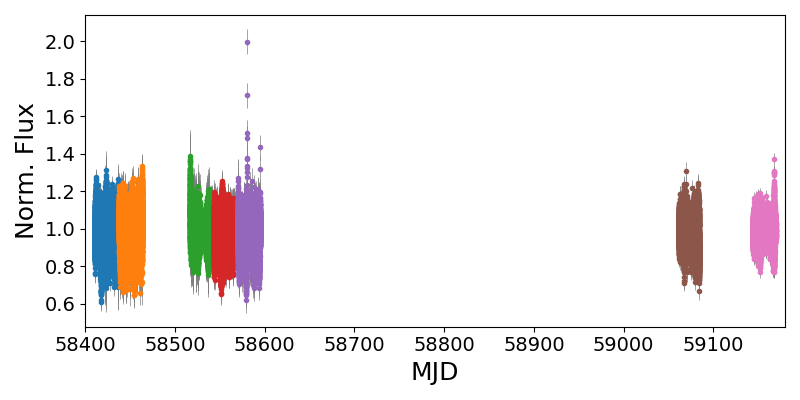

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(8.,4.))
colorlist = ['C0','C1','C2','C3','C4','C5','C6']
for i in range(7):
    plt.errorbar(scrubbedtimes[i],normalizedFluxes[i].value,yerr=normalizedFluxerrs[i].value,ecolor='gray',elinewidth=0.5,fmt=('.'+colorlist[i]))
plt.xlabel('MJD',fontsize=18)
plt.ylabel('Norm. Flux',fontsize=18)
plt.xlim([58400.,59180])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


Try plotting with Plotly

In [ ]:
testfig = go.Figure(data=go.Bar(y=[2, 3, 1]))
testfig.write_html('first_figure.html', auto_open=True)

In [ ]:
import plotly.express as px

In [ ]:
testfig1 = go.Figure(data=go.Scatter(
        x=[0, 1, 2],
        y=[6, 10, 2],
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=[1, 2, 3],
            visible=True)
    ))
testfig1.show()

In [14]:
newfig = go.Figure()

sectornumbers = [4,5,8,9,10,28,31]

labels = ['Sector '+str(x) for x in sectornumbers]
print(labels)

for i in range(7):
    #scrubbedtimes[i],normalizedFluxes[i].value,yerr=normalizedFluxerrs[i].value,ecolor='gray',elinewidth=0.5,fmt=('.'+colorlist[i]))
    newfig.add_trace(go.Scatter(x=scrubbedtimes[i], y=normalizedFluxes[i].value, error_y=dict(type='data', array=normalizedFluxerrs[i].value, visible=True),mode='markers',name=labels[i]))
    
newfig.update_layout(
    title="TESS Data on J0808",
    xaxis_title="MJD",
    yaxis_title="Normalized Flux",
    font=dict(
        family="Helvetica",
        size=18,
        color="Black"
    )
)
    
newfig.write_html('testfig_plotly.html', auto_open=True)

['Sector 4', 'Sector 5', 'Sector 8', 'Sector 9', 'Sector 10', 'Sector 28', 'Sector 31']
